<a href="https://colab.research.google.com/github/dkant000/ML_PROJECT/blob/UrbansoundDetect/URBAN_SOUND_DescriptiveAnalysis%5B1%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up

In [ ]:
pip install scikit_posthocs

     |████████████████████████████████| 51kB 2.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-posthocs: filename=scikit_posthocs-0.6.7-cp37-none-any.whl size=37886 sha256=9e3dcaed146a978a3e90cb8418e972ba8a32847ce2d9263af252bcc846d5caf9
  Stored in directory: /root/.cache/pip/wheels/00/0f/56/897c22820a48a74f50f1a85faaa4b133bb8865e8b094b596f5
Successfully built scikit-posthocs


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from librosa import display
import librosa
import IPython.display
import glob
from scipy.stats import chi2_contingency, kruskal
import scikit_posthocs as sp


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Mounting drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''
create basedir path to where the urban sounds folder is saved in your drive

'''

basedir = '/content/drive/MyDrive/data'


In [ ]:
'''
load .csv for data analysis
'''
# path 
df = pd.read_csv(os.path.join(basedir, 'UrbanSound8K.csv'))

In [ ]:
'''
if not uploaded the file to google drive:
load in the data set from external url
WARNING: takes around 15 minutes to run
'''

# import urllib.request
# urllib.request.urlretrieve ("https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz","a.tar.gz")
# import tarfile
# tar = tarfile.open("a.tar.gz")
# tar.extractall()
# tar.close()

## Brief Overview (Info taken from the README file included in the dataset)

This dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: 
- air conditioner
- car horn, 
- children playing
- dog bark
- drilling
- engine idling
- gun shot
- jackhammer
- siren
- street music

Info on the csv file:

This file contains meta-data information about every audio file in the dataset. This includes:

* slice_file_name: 
The name of the audio file. The name takes the following format: [fsID]-[classID]-[occurrenceID]-[sliceID].wav, where:
    - [fsID] = the Freesound ID of the recording from which this excerpt (slice) is taken
    - [classID] = a numeric identifier of the sound class (see description of classID below for further details)
    - [occurrenceID] = a numeric identifier to distinguish different occurrences of the sound within the original recording
    - [sliceID] = a numeric identifier to distinguish different slices taken from the same occurrence

* fsID:
The Freesound ID of the recording from which this excerpt (slice) is taken

* start
The start time of the slice in the original Freesound recording

* end:
The end time of slice in the original Freesound recording

* salience:
A (subjective) salience rating of the sound. 1 = foreground, 2 = background.

* fold:
The fold number (1-10) to which this file has been allocated.

* classID: A numeric identifier of the sound class:
    - 0 = air_conditioner
    - 1 = car_horn
    - 2 = children_playing
    - 3 = dog_bark
    - 4 = drilling
    - 5 = engine_idling
    - 6 = gun_shot
    - 7 = jackhammer
    - 8 = siren
    - 9 = street_music

* class: the class name



## Data Analysis

This section contains:

- Visualisation of data (e.g. of some wav files)
- An overview of the csv file (e.g. number of files in each category)
- Statistics used to complement the descriptive analysis of the dataset
- Creation of .pkl files to use for pre-processing and model building

In [ ]:
# Dataframe structure
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [ ]:
# Information about each type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


In [ ]:
# Data balance overview
# Number of samples for each class
df['classID'].value_counts()

7    1000
5    1000
4    1000
3    1000
2    1000
9    1000
0    1000
8     929
1     429
6     374
Name: classID, dtype: int64

In [ ]:
# Number of samples per fold
df['fold'].value_counts()

4     990
5     936
3     925
2     888
1     873
7     838
10    837
6     823
9     816
8     806
Name: fold, dtype: int64

Text(0.5, 1.0, 'Number of samples for each class')

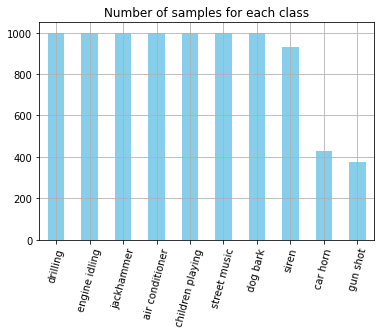

In [ ]:
# Visualising sorted number of samples per class for data imbalance
class_counts = df['class'].value_counts(sort=True)
class_counts.plot.bar(color = 'skyblue')

class_labels_temp = [i.replace("_", " ") for i in class_counts.index.values]

plt.xticks(range(len(class_counts)), class_labels_temp)
plt.xticks(rotation=75)
plt.grid()
plt.title('Number of samples for each class')

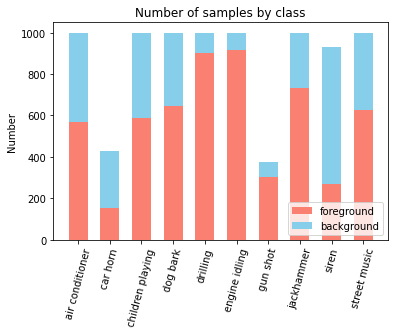

In [ ]:
'''
Number of samples per class and by salience
'''
# class labels in order by ID
class_labels = ["air conditioner", "car horn", "children playing", 
                "dog bark", "drilling", "engine idling", "gun shot", 
                "jackhammer", "siren", "street music"]

# sound types
foreground = df[df['salience'] == 1]['classID'].value_counts().sort_index().values
background = df[df['salience'] == 2]['classID'].value_counts().sort_index().values

# plotting
width = 0.6
fig, ax = plt.subplots()

ax.bar(class_labels, foreground, width,label='foreground', color = 'salmon')
ax.bar(class_labels, background, width,bottom=foreground,
       label='background', color='skyblue')
ax.set_ylabel('Number')
ax.set_title('Number of samples by class')
ax.legend(loc=4)
plt.xticks(rotation=75)

plt.show()

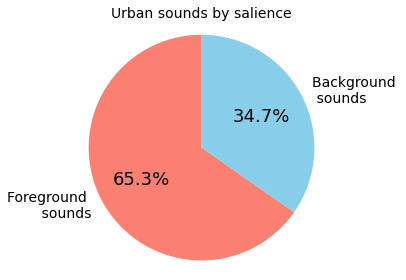

In [ ]:
'''
Pie chart visualisation of proportion between background and foreground sounds
'''
labels = ['Foreground \n sounds', 'Background \n sounds']
fgval = df[df['salience'] == 1].shape[0]
bgval = df[df['salience'] == 2].shape[0]

fig, ax = plt.subplots()
patches, outsidetext, insidetext = ax.pie([fgval, bgval], colors = ['salmon', 'skyblue'], labels=labels, autopct='%1.1f%%', startangle=90)

for text in outsidetext:
    text.set_size(14)

for text in insidetext:
    text.set_size(18)
ax.axis('equal')
# ax.legend(loc= 4)
plt.title('Urban sounds by salience', fontsize= 14)
plt.tight_layout()
plt.show()

In [ ]:
# metafile shape
print('Metafile shape: ' + str(df.shape))
print('\n')

# check for NaN values in metafile
print('Checking for missing values in metafile:')
print(df.isnull().values.any())

Metafile shape: (8732, 8)


Checking for missing values in metafile:
False


In [ ]:
'''
Chi-square test for independence.
Measuring the relation between foreground and background noises
'''
                
foreground = df[df['salience'] == 1]['classID'].value_counts().sort_index().values
background = df[df['salience'] == 2]['classID'].value_counts().sort_index().values
table = [foreground, background]
stat, p, dof, expected = chi2_contingency(table)
print('P-value: {}' .format(p))

P-value: 7.695658468073049e-298


**Result.** We can reject the null hypothesis with alpha = 0.05, as p-value < 0.05, meaning that salience and classes are dependent, there is association between variables. (but it is kind of obvious because there are way more foreground samples)

Ways of Visualising sounds (which are also the features we will use for the model):
- MFCC
- Melspectogram
- Chromagram
- Chroma cqt
- Chroma cens

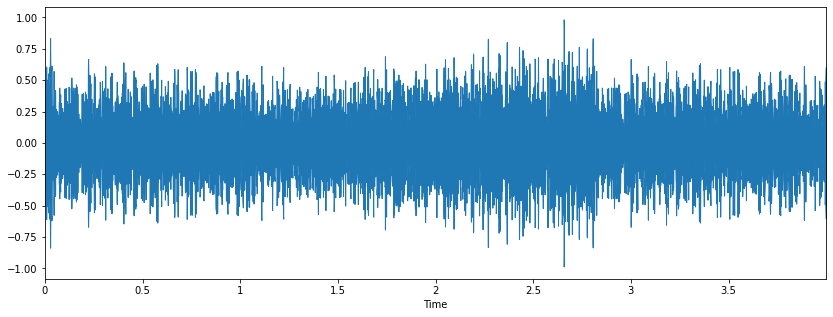

In [ ]:
#e.g. to load audio file
#librosa.load returns an array (y here) and a sampling rate (sr - default 22050 = 22kHz)

y,sr=librosa.load(os.path.join(basedir, "audio/fold9/12812-5-0-0.wav"))
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr)

IPython.display.Audio(y, rate=sr)

Using glob package to make list for each sound path. <br>
We can also do that for each fold separately.

In [ ]:
sounds = glob.glob(basedir + '/audio/*' + '/*.wav') # a list of paths for each sound

# to make sure it the shape is of 8732 rows
print(len(sounds))

8732


**Creating .pkl files** <br>
We can further read all files with Librosa and put sample rate and sample numbers into lists and create one dataframe with them. To avoid reading all sounds with Librosa, we can save created dataframe into pickle type files. It allows to read dataframe directly from pickle files whenever we want toinstead of reading with Librosa each time.

In [ ]:
# # DO NOT RUN THIS CODE BLOCK! 

# sr_list = []
# y_list = []
# name_list = []


# for no, file in enumerate(sounds):
#   if no%500 == 0:
#     print('currently at: ' + str(no))

#   y, sr = librosa.load(file)

#   name = file.split('/')[-1]


#   sr_list.append(sr)
#   y_list.append(y)
#   name_list.append(name)


# # creating dataframe with extracted sound information
# sounds_df = pd.DataFrame({
#     'name': name_list,
#     'sr': sr_list,
#      'y': y_list})

In [ ]:
# # DO NOT RUN THIS CODE BLOCK! 
# # joining metafile information with extracted sample info
# sounds_df = sounds_df.join(df.set_index('slice_file_name'), on='name')

In [ ]:
# # DO NOT RUN THIS CODE BLOCK!
# # checking sounds_df
# sounds_df.tail()

In [ ]:
# # DO NOT RUN THIS CODE BLOCK! 
# # to put data frames into pickle files for later
# for i in np.arange(1,11):
#   sounds_df[sounds_df['fold'] == i].to_pickle('fold'+str(i)+'.pkl')
#   print(i)

This is how to read pickle files from Google Drive. Please upload to your drive instead of colab directly. If you have mounted drive with files, reading them wont take longer than a minute. The link for files: <br>
https://drive.google.com/file/d/1cLkb3GCUI-QU4RM5N0qH4M7ivesQQS9O/view?usp=sharing

In [ ]:

pickle_files_path = '/content/drive/MyDrive/data/data_pkl/'

In [ ]:
'''
creates dataframe "df_urban_sounds" with information about samples
also creates 10 different dataframes "df_fold1, df_fold2, etc" for each fold
'''
appended_data = []
for i in np.arange(1,11):
  print('Writing fold no.{}'.format(i))
  vars()['df_fold' + str(i)] = pd.read_pickle(pickle_files_path + 'fold' + str(i) + '.pkl')
  appended_data.append(vars()['df_fold' + str(i)])
df_urban_sounds = pd.concat(appended_data, ignore_index=True)

Writing fold no.1
Writing fold no.2
Writing fold no.3
Writing fold no.4
Writing fold no.5
Writing fold no.6
Writing fold no.7
Writing fold no.8
Writing fold no.9
Writing fold no.10


In [ ]:
'''
Created dataframe contains information about samples, where columns "sr" is sample rate and "y" is a list of recorded samples
'''

df_urban_sounds.head()

,name,sr,y,fsID,start,end,salience,fold,classID,class
0,101415-3-0-2.wav,22050,"[-0.00011783496, -0.00017157062, -0.0001774939...",101415,1.000000,5.000000,1,1,3,dog_bark
1,101415-3-0-8.wav,22050,"[0.23950581, 0.35340017, 0.29654667, 0.2917560...",101415,4.000000,8.000000,1,1,3,dog_bark
2,103074-7-0-2.wav,22050,"[0.0081740115, -0.0015046991, -0.0086963875, -...",103074,4.341279,8.341279,1,1,7,jackhammer
3,102842-3-1-0.wav,22050,"[0.007395301, 0.00981416, 0.00828659, 0.008712...",102842,113.061785,117.061785,2,1,3,dog_bark
4,101415-3-0-3.wav,22050,"[-0.0006034802, -0.0010423105, -0.0008373572, ...",101415,1.500000,5.500000,1,1,3,dog_bark


In [ ]:
# example 1. using full "df_urban_sounds"

print('Sample name:')
print(df_urban_sounds.iloc[0]['name'])

print('\n Sample rate:')
print(df_urban_sounds.iloc[0]['sr'])

print('\n Number of samples:')
print(df_urban_sounds.iloc[0]['y'])

Sample name:
101415-3-0-2.wav

 Sample rate:
22050

 Number of samples:
[-0.00011783 -0.00017157 -0.00017749 ... -0.04598654 -0.04624664
 -0.05089863]


In [ ]:
# example 2. using "df_fold1"

print('Sample name:')
print(df_fold1.iloc[0]['name'])

print('\n Sample rate:')
print(df_fold1.iloc[0]['sr'])

print('\n Number of samples:')
print(df_fold1.iloc[0]['y'])

Sample name:
101415-3-0-2.wav

 Sample rate:
22050

 Number of samples:
[-0.00011783 -0.00017157 -0.00017749 ... -0.04598654 -0.04624664
 -0.05089863]


In [ ]:
'''
Calcualting sample exact length of the samples by dividing frame rate and number of frames
'''

duration_list = []
for i in range(df_urban_sounds.shape[0]):
  dur = len(df_urban_sounds.iloc[i]['y'])/df_urban_sounds.iloc[i]['sr']
  duration_list.append(dur)

# adding new column of lengths
df_urban_sounds['length'] = duration_list

df_urban_sounds.tail()

,name,sr,y,fsID,start,end,salience,fold,classID,class,length
8727,99192-4-0-53.wav,22050,"[0.059988726, 0.061065044, 0.16498338, 0.14804...",99192,26.5,30.5,1,10,4,drilling,4.0
8728,99192-4-0-55.wav,22050,"[0.01473959, 0.022773646, 0.05025508, 0.058404...",99192,27.5,31.5,1,10,4,drilling,4.0
8729,99192-4-0-54.wav,22050,"[0.005095922, 0.014739645, 0.011429922, -0.000...",99192,27.0,31.0,1,10,4,drilling,4.0
8730,99192-4-0-52.wav,22050,"[-0.008036119, -0.019243455, -0.013388598, 0.0...",99192,26.0,30.0,1,10,4,drilling,4.0
8731,99192-4-0-7.wav,22050,"[0.024699196, 0.0069064884, 0.03016094, 0.0363...",99192,3.5,7.5,1,10,4,drilling,4.0


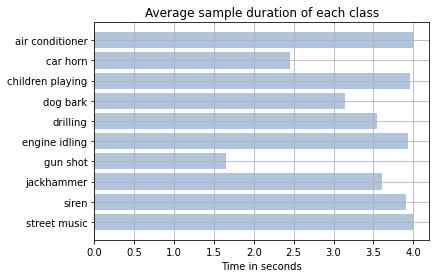

In [ ]:
'''
Visualising average duration per sample
'''

avg_len = []
for i in np.arange(0,10):
  avg_dur = np.average(df_urban_sounds[df_urban_sounds['classID'] == i]['length'].values)
  avg_len.append(avg_dur)

# class labels in order
class_labels = ["air conditioner", "car horn", "children playing", 
                "dog bark", "drilling", "engine idling", "gun shot", 
                "jackhammer", "siren", "street music"]

# plotting
plt.yticks(range(len(avg_len[::-1])), class_labels[::-1])
plt.xlabel('Time in seconds')
plt.title('Average sample duration of each class')
plt.barh(range(len(avg_len[::-1])), avg_len[::-1], color='lightsteelblue')
plt.grid()
plt.show()

In [ ]:
'''
Kruskal-Wallis test
Measuring class significance on the length of audio sample
'''

for i in np.arange(0,10):
  vars()['cl' + str(i)]  = df_urban_sounds[df_urban_sounds['classID'] == i]['length'].values.tolist()

kruskal(cl0, cl1, cl2, cl3, cl4, cl5, cl6, cl7, cl8, cl9)

KruskalResult(statistic=3170.673555048203, pvalue=0.0)

**Result.** Since p-value is less than alpha = 0.05, we can reject the null hypothesis and state that the median of sample lengths between classes is the same. There is significant difference between duration of the samples.

In [ ]:
'''
Post-hoc test
Since we rejected null hypothesis of Krsukal-Wallis test,
we can further measure pairwise significane between audio duration of classes 
'''

cl = [cl0, cl1, cl2, cl3, cl4, cl5, cl6, cl7, cl8, cl9]
df_PH_test = sp.posthoc_dunn(cl)
df_PH_test.columns = class_labels
df_PH_test['classes'] = class_labels
df_PH_test = df_PH_test.set_index('classes')

df_PH_test

,air conditioner,car horn,children playing,dog bark,drilling,engine idling,gun shot,jackhammer,siren,street music
classes,,,,,,,,,,
air conditioner,1.000000e+00,3.813051e-148,4.208786e-01,1.280484e-87,3.404058e-30,4.309576e-02,0.000000e+00,5.510650e-29,5.565449e-02,8.688863e-01
car horn,3.813051e-148,1.000000e+00,3.377310e-141,5.288608e-26,2.312161e-65,5.245247e-131,1.029156e-51,8.830716e-67,1.067326e-128,1.366577e-149
children playing,4.208786e-01,3.377310e-141,1.000000e+00,8.332333e-81,2.593153e-26,2.232685e-01,0.000000e+00,3.453156e-25,2.611042e-01,3.320608e-01
dog bark,1.280484e-87,5.288608e-26,8.332333e-81,1.000000e+00,3.620843e-17,4.972449e-71,6.729628e-169,4.352664e-18,4.975770e-69,4.735465e-89
drilling,3.404058e-30,2.312161e-65,2.593153e-26,3.620843e-17,1.000000e+00,5.715954e-21,3.710524e-252,8.067613e-01,1.513311e-20,5.027864e-31
engine idling,4.309576e-02,5.245247e-131,2.232685e-01,4.972449e-71,5.715954e-21,1.000000e+00,0.000000e+00,5.667008e-20,9.430202e-01,2.868024e-02
gun shot,0.000000e+00,1.029156e-51,0.000000e+00,6.729628e-169,3.710524e-252,0.000000e+00,1.000000e+00,7.972664e-255,0.000000e+00,0.000000e+00
jackhammer,5.510650e-29,8.830716e-67,3.453156e-25,4.352664e-18,8.067613e-01,5.667008e-20,7.972664e-255,1.000000e+00,1.403769e-19,8.472191e-30
siren,5.565449e-02,1.067326e-128,2.611042e-01,4.975770e-69,1.513311e-20,9.430202e-01,0.000000e+00,1.403769e-19,1.000000e+00,3.791816e-02


**Result.** With selected alpha = 0.05, obtained results stuggests that the lengths of classes: "car_horn", "dog_bark" and "gun_shot” are statistically different among themselves and every other pair.

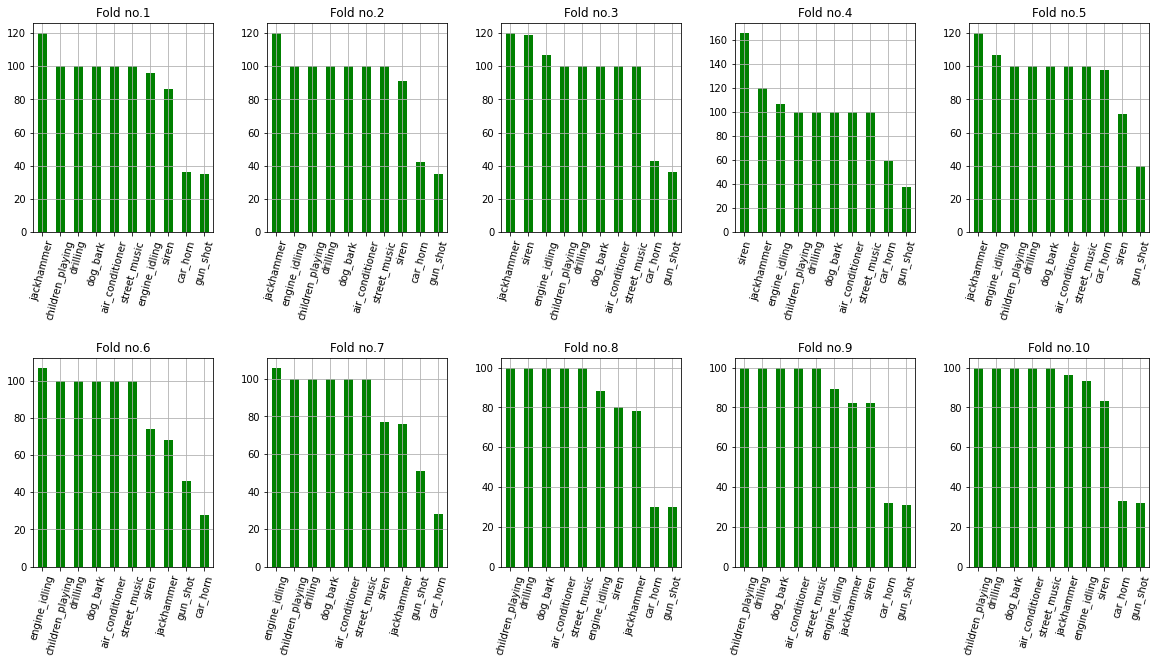

In [ ]:
'''
Visualising each fold imbalance
'''

fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=0.6, wspace=0.3)

for i in np.arange(1,11):
  ax = fig.add_subplot(2, 5, i)
  vars()['df_fold' + str(i)]['class'].value_counts(sort=True).plot.bar(color = 'g')
  plt.title('Fold no.' + str(i))
  plt.xticks(rotation=75)
  plt.grid()

plt.show()

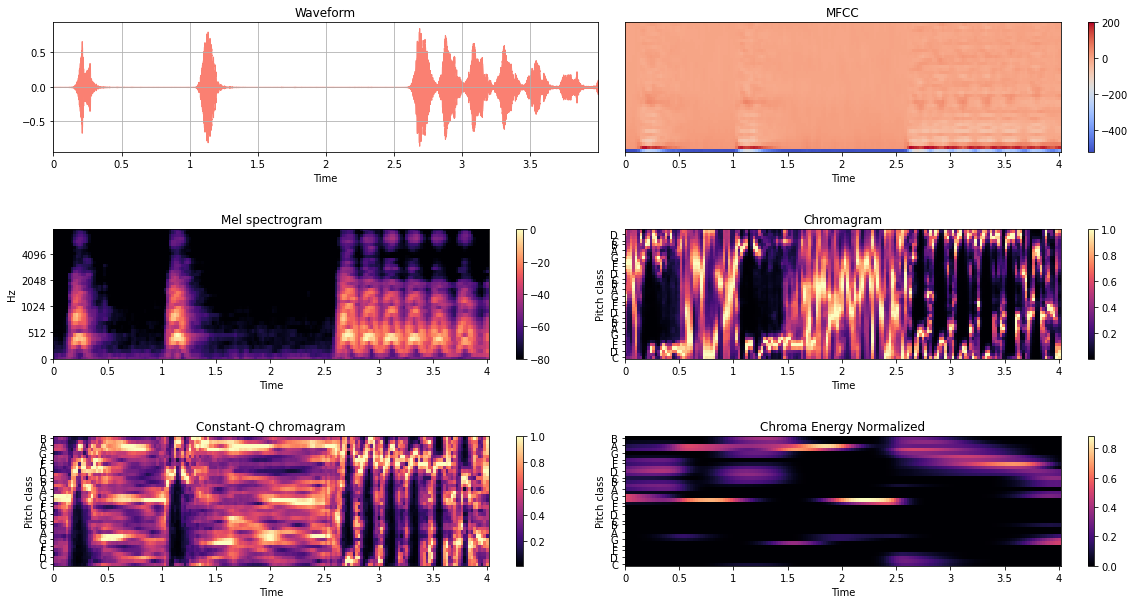

In [ ]:
'''
Audio sample visualisation
'''

# read
sr, y = df_fold1.iloc[0]['sr'], df_fold1.iloc[0]['y']

mfccs = librosa.feature.mfcc(y, sr, n_mfcc=40)
melspectrogram =librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40,fmax=8000)
chroma_stft=librosa.feature.chroma_stft(y=y, sr=sr,n_chroma=40)
chroma_cq =librosa.feature.chroma_cqt(y=y, sr=sr,n_chroma=36)
chroma_cens =librosa.feature.chroma_cens(y=y, sr=sr,n_chroma=36)

# plot
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=0.6, wspace=0.05)

ax = fig.add_subplot(3, 2, 1)
librosa.display.waveplot(y, sr=sr, color='salmon')
plt.grid()
plt.title('Waveform')

ax = fig.add_subplot(3, 2, 2)
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')

ax = fig.add_subplot(3, 2, 3)
librosa.display.specshow(librosa.power_to_db(melspectrogram,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')
plt.colorbar()
plt.title('Mel spectrogram')


ax = fig.add_subplot(3, 2, 4)
librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')

ax = fig.add_subplot(3, 2, 5)
librosa.display.specshow(chroma_cq, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Constant-Q chromagram')

ax = fig.add_subplot(3, 2, 6)
librosa.display.specshow(chroma_cens, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chroma Energy Normalized')
plt.show()

Additional visualisation of 'Street music' sample for the report

In [ ]:

sr, y = df_fold7.iloc[0]['sr'], df_fold7.iloc[0]['y']
name = 'Street music'
mfccs = librosa.feature.mfcc(y, sr, n_mfcc=40)
melspectrogram =librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40,fmax=8000)
chroma_stft=librosa.feature.chroma_stft(y=y, sr=sr,n_chroma=40)
chroma_cq =librosa.feature.chroma_cqt(y=y, sr=sr,n_chroma=36)
chroma_cens =librosa.feature.chroma_cens(y=y, sr=sr,n_chroma=36)


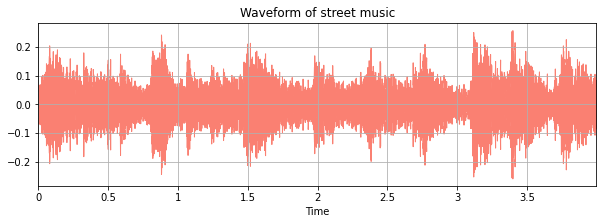

In [ ]:
fig = plt.figure(figsize=(10, 3))
librosa.display.waveplot(y, sr=sr, color='salmon')
plt.grid()
plt.title('Waveform of street music')
plt.show()
fig.savefig('wavelet.png')

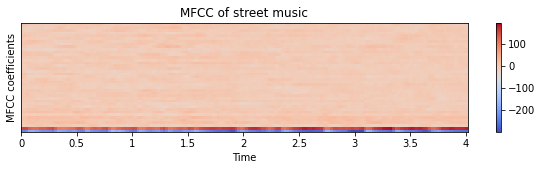

In [ ]:
fig = plt.figure(figsize=(10, 2))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.ylabel('MFCC coefficients')
plt.yticks()
plt.title('MFCC of street music')
fig.savefig('mfcc.png')

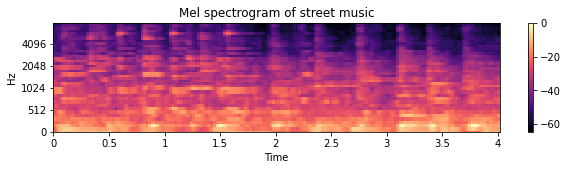

In [ ]:
fig = plt.figure(figsize=(10, 2))
librosa.display.specshow(librosa.power_to_db(melspectrogram,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')
plt.colorbar()
plt.title('Mel spectrogram of street music')
fig.savefig('mel.png')

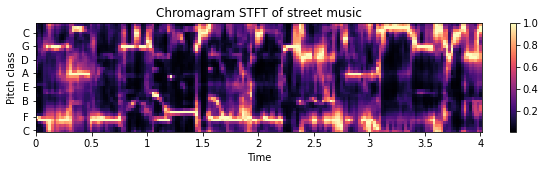

In [ ]:
fig = plt.figure(figsize=(10, 2))
librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.locator_params(axis='y', nbins=24) 

plt.title('Chromagram STFT of street music')
fig.savefig('chromagramstft.png')

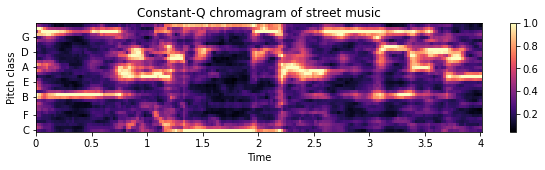

In [ ]:
fig = plt.figure(figsize=(10, 2))
librosa.display.specshow(chroma_cq, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.locator_params(axis='y', nbins=24) 

plt.title('Constant-Q chromagram of street music')
fig.savefig('constantq.png')

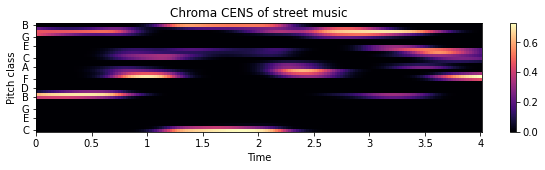

In [ ]:
fig = plt.figure(figsize=(10, 2))
librosa.display.specshow(chroma_cens, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chroma CENS of street music')
plt.locator_params(axis='y', nbins=36) 
plt.show()
fig.savefig('chromaens.png')